In [1]:
# %pip install tqdm
# %pip install python-dotenv
# %pip install torch==2.4.0+cu118
# %pip install scikit_learn==1.2.2
# %pip install ipython
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install tabulate
# %pip install scipy
# %pip install git+https://github.com/Louis-Li-dev/ML_tool_kit

In [2]:
import os
import sys
parent_dir = os.path.join(os.getcwd(), '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility.data_utils import *
from utility.visuals import *
from dotenv import load_dotenv
from model.CNN import ConditionalSegmentationVAE
from mkit.torch_support.tensor_utils import xy_to_tensordataset
from torch import nn
from IPython.display import clear_output
from sklearn.ensemble import RandomForestRegressor
load_dotenv()
DATA_DIR = os.getenv("DATA_DIR")

- Dataset

In [3]:
if not os.path.exists(DATA_DIR): raise FileNotFoundError("Make sure the data directory is correctly placed.")

In [4]:
files = get_files(DATA_DIR)

return_list = []
file = files[0]
city_name = file.split('\\')[-1].split('.csv')[0].split('_')[0]

path_name = process_and_transform_data(file, resolution=.5, overwrite=True)
with open(path_name, 'rb') as f:
    result_dict = pickle.load(f)
labels = result_dict['labels']
encoder = result_dict['encoder']
MAX_LEN = result_dict['max length']
file_name = result_dict['file name']
WIDTH = result_dict['width']
HEIGHT = result_dict['height']

original dataset size: 238
dataset size with duplicates removed: 172


- x y splitting

In [5]:
x_list, y_list, y_one_hot_list, y_seq_list =  get_x_y(labels, encoder, MAX_LEN)
# x_list -> 2D inputs including order
# y_list -> same as x
# y_one_hot_list -> non-ordered list
# y_seq_list -> it contains arrays of label-encoded locations as sequences

- data processing

In [6]:

loader, val_loader, test_loader = xy_to_tensordataset(
    np.expand_dims(np.array(x_list), 1), np.array(y_one_hot_list),
    return_loader=True, 
    batch_size=8,
    input_dtype=torch.float32,
    output_dtype=torch.float32,
    val_ratio=.15,
    test_ratio=.15
)

- For Machine Learning Models
    - To fit the data formats of tensors, every sci-kit learn model needs to be wrapped inside the object MLWrapper

In [7]:
class MLWrapper(nn.Module):
    def __init__(self, model_object = RandomForestRegressor, **args):
        self.model = model_object(**args)
        self.device = torch.device('cpu')
    def loader_to_xy(self, loader):
        x, y = loader.dataset.tensors
        x, y = np.array(x).squeeze(1), np.array(y)
        x = x.reshape(x.shape[0], -1)
        return x, y
    def fit(self, train_loader, val_loader):
        train_x, train_y = self.loader_to_xy(train_loader)
        val_train_x, val_train_y = self.loader_to_xy(val_loader)
        self.model.fit(train_x, train_y)
        accu = self.model.score(val_train_x, val_train_y)
        print(accu)
    def inference(self, img):
        batch_size, _, _, _ = img.shape
        img = img.reshape(batch_size, -1)
        return torch.tensor(self.model.predict(img))

- VAE

In [8]:
IMG_CHANNELS = 1    # For grayscale images; use 3 for RGB.
N_EPOCHS = 100      # Adjust as needed.
LATENT_DIM = 300    # Dimensionality of the latent space.
FEATURE_MAPS = 8    # Base number of feature maps.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConditionalSegmentationVAE(
    latent_dim=LATENT_DIM,
    width=WIDTH,
    height=HEIGHT,
    img_channels=IMG_CHANNELS,
    feature_maps=FEATURE_MAPS,
    device=device
)

segmentation_loss_fn = nn.BCEWithLogitsLoss().to(device)

# Assume your train_loader and val_loader are defined appropriately.
model.train_vae(
    train_loader=loader,       # your training DataLoader
    val_loader=val_loader,       # your validation DataLoader
    n_epochs=N_EPOCHS,
    seg_criterion=segmentation_loss_fn,
    kl_weight=0.001,
    patience=10,
    device=device
)
clear_output(wait=True)

Epoch 1/100: 100%|██████████| 15/15 [00:01<00:00, 11.37it/s]


Epoch [1/100], Train Loss: 0.7098, Val Loss: 0.7602
Validation loss improved to 0.7602.


Epoch 2/100: 100%|██████████| 15/15 [00:00<00:00, 78.13it/s]


Epoch [2/100], Train Loss: 0.5742, Val Loss: 0.5757
Validation loss improved to 0.5757.


Epoch 3/100: 100%|██████████| 15/15 [00:00<00:00, 62.76it/s]


Epoch [3/100], Train Loss: 0.4834, Val Loss: 0.4639
Validation loss improved to 0.4639.


Epoch 4/100: 100%|██████████| 15/15 [00:00<00:00, 70.09it/s]


Epoch [4/100], Train Loss: 0.4121, Val Loss: 0.4000
Validation loss improved to 0.4000.


Epoch 5/100: 100%|██████████| 15/15 [00:00<00:00, 80.47it/s]


Epoch [5/100], Train Loss: 0.3521, Val Loss: 0.3317
Validation loss improved to 0.3317.


Epoch 6/100: 100%|██████████| 15/15 [00:00<00:00, 76.12it/s]


Epoch [6/100], Train Loss: 0.2999, Val Loss: 0.2535
Validation loss improved to 0.2535.


Epoch 7/100: 100%|██████████| 15/15 [00:00<00:00, 71.17it/s]


Epoch [7/100], Train Loss: 0.2559, Val Loss: 0.2356
Validation loss improved to 0.2356.


Epoch 8/100: 100%|██████████| 15/15 [00:00<00:00, 70.63it/s]


Epoch [8/100], Train Loss: 0.2197, Val Loss: 0.1935
Validation loss improved to 0.1935.


Epoch 9/100: 100%|██████████| 15/15 [00:00<00:00, 82.14it/s]


Epoch [9/100], Train Loss: 0.1907, Val Loss: 0.1668
Validation loss improved to 0.1668.


Epoch 10/100: 100%|██████████| 15/15 [00:00<00:00, 79.88it/s]


Epoch [10/100], Train Loss: 0.1669, Val Loss: 0.1611
Validation loss improved to 0.1611.


Epoch 11/100: 100%|██████████| 15/15 [00:00<00:00, 87.67it/s]

Epoch [11/100], Train Loss: 0.1477, Val Loss: 0.1452


Validation loss improved to 0.1452.


Epoch 12/100: 100%|██████████| 15/15 [00:00<00:00, 98.25it/s]


Epoch [12/100], Train Loss: 0.1317, Val Loss: 0.1410
Validation loss improved to 0.1410.


Epoch 13/100: 100%|██████████| 15/15 [00:00<00:00, 96.27it/s]

Epoch [13/100], Train Loss: 0.1185, Val Loss: 0.1234


Validation loss improved to 0.1234.


Epoch 14/100: 100%|██████████| 15/15 [00:00<00:00, 97.26it/s] 


Epoch [14/100], Train Loss: 0.1073, Val Loss: 0.1050
Validation loss improved to 0.1050.


Epoch 15/100: 100%|██████████| 15/15 [00:00<00:00, 97.22it/s]


Epoch [15/100], Train Loss: 0.0978, Val Loss: 0.1049
Validation loss improved to 0.1049.


Epoch 16/100: 100%|██████████| 15/15 [00:00<00:00, 89.20it/s]

Epoch [16/100], Train Loss: 0.0898, Val Loss: 0.0926


Validation loss improved to 0.0926.


Epoch 17/100: 100%|██████████| 15/15 [00:00<00:00, 97.63it/s]

Epoch [17/100], Train Loss: 0.0826, Val Loss: 0.0891


Validation loss improved to 0.0891.


Epoch 18/100: 100%|██████████| 15/15 [00:00<00:00, 99.01it/s]


Epoch [18/100], Train Loss: 0.0763, Val Loss: 0.0829
Validation loss improved to 0.0829.


Epoch 19/100: 100%|██████████| 15/15 [00:00<00:00, 94.27it/s]


Epoch [19/100], Train Loss: 0.0709, Val Loss: 0.0732
Validation loss improved to 0.0732.


Epoch 20/100: 100%|██████████| 15/15 [00:00<00:00, 99.97it/s] 


Epoch [20/100], Train Loss: 0.0660, Val Loss: 0.0716
Validation loss improved to 0.0716.


Epoch 21/100: 100%|██████████| 15/15 [00:00<00:00, 93.43it/s]


Epoch [21/100], Train Loss: 0.0618, Val Loss: 0.0673
Validation loss improved to 0.0673.


Epoch 22/100: 100%|██████████| 15/15 [00:00<00:00, 84.10it/s]


Epoch [22/100], Train Loss: 0.0579, Val Loss: 0.0625
Validation loss improved to 0.0625.


Epoch 23/100: 100%|██████████| 15/15 [00:00<00:00, 93.99it/s]


Epoch [23/100], Train Loss: 0.0543, Val Loss: 0.0576
Validation loss improved to 0.0576.


Epoch 24/100: 100%|██████████| 15/15 [00:00<00:00, 74.96it/s]


Epoch [24/100], Train Loss: 0.0511, Val Loss: 0.0554
Validation loss improved to 0.0554.


Epoch 25/100: 100%|██████████| 15/15 [00:00<00:00, 88.23it/s]


Epoch [25/100], Train Loss: 0.0483, Val Loss: 0.0529
Validation loss improved to 0.0529.


Epoch 26/100: 100%|██████████| 15/15 [00:00<00:00, 88.79it/s]

Epoch [26/100], Train Loss: 0.0458, Val Loss: 0.0484


Validation loss improved to 0.0484.


Epoch 27/100: 100%|██████████| 15/15 [00:00<00:00, 85.84it/s]


Epoch [27/100], Train Loss: 0.0434, Val Loss: 0.0455
Validation loss improved to 0.0455.


Epoch 28/100: 100%|██████████| 15/15 [00:00<00:00, 86.58it/s]


Epoch [28/100], Train Loss: 0.0412, Val Loss: 0.0439
Validation loss improved to 0.0439.


Epoch 29/100: 100%|██████████| 15/15 [00:00<00:00, 65.47it/s]


Epoch [29/100], Train Loss: 0.0392, Val Loss: 0.0435
Validation loss improved to 0.0435.


Epoch 30/100: 100%|██████████| 15/15 [00:00<00:00, 72.16it/s]


Epoch [30/100], Train Loss: 0.0374, Val Loss: 0.0397
Validation loss improved to 0.0397.


Epoch 31/100: 100%|██████████| 15/15 [00:00<00:00, 82.84it/s]


Epoch [31/100], Train Loss: 0.0358, Val Loss: 0.0361
Validation loss improved to 0.0361.


Epoch 32/100: 100%|██████████| 15/15 [00:00<00:00, 86.79it/s]


Epoch [32/100], Train Loss: 0.0342, Val Loss: 0.0346
Validation loss improved to 0.0346.


Epoch 33/100: 100%|██████████| 15/15 [00:00<00:00, 81.05it/s]


Epoch [33/100], Train Loss: 0.0327, Val Loss: 0.0327
Validation loss improved to 0.0327.


Epoch 34/100: 100%|██████████| 15/15 [00:00<00:00, 79.69it/s]


Epoch [34/100], Train Loss: 0.0314, Val Loss: 0.0321
Validation loss improved to 0.0321.


Epoch 35/100: 100%|██████████| 15/15 [00:00<00:00, 75.49it/s]


Epoch [35/100], Train Loss: 0.0301, Val Loss: 0.0311
Validation loss improved to 0.0311.


Epoch 36/100: 100%|██████████| 15/15 [00:00<00:00, 87.46it/s]


Epoch [36/100], Train Loss: 0.0290, Val Loss: 0.0298
Validation loss improved to 0.0298.


Epoch 37/100: 100%|██████████| 15/15 [00:00<00:00, 84.45it/s]


Epoch [37/100], Train Loss: 0.0278, Val Loss: 0.0284
Validation loss improved to 0.0284.


Epoch 38/100: 100%|██████████| 15/15 [00:00<00:00, 77.89it/s]


Epoch [38/100], Train Loss: 0.0268, Val Loss: 0.0276
Validation loss improved to 0.0276.


Epoch 39/100: 100%|██████████| 15/15 [00:00<00:00, 80.76it/s]


Epoch [39/100], Train Loss: 0.0258, Val Loss: 0.0272
Validation loss improved to 0.0272.


Epoch 40/100: 100%|██████████| 15/15 [00:00<00:00, 88.18it/s]

Epoch [40/100], Train Loss: 0.0249, Val Loss: 0.0252


Validation loss improved to 0.0252.


Epoch 41/100: 100%|██████████| 15/15 [00:00<00:00, 85.38it/s]


Epoch [41/100], Train Loss: 0.0241, Val Loss: 0.0248
Validation loss improved to 0.0248.


Epoch 42/100: 100%|██████████| 15/15 [00:00<00:00, 86.48it/s]

Epoch [42/100], Train Loss: 0.0232, Val Loss: 0.0252


No improvement for 1 epoch(s).


Epoch 43/100: 100%|██████████| 15/15 [00:00<00:00, 77.85it/s]


Epoch [43/100], Train Loss: 0.0225, Val Loss: 0.0251
No improvement for 2 epoch(s).


Epoch 44/100: 100%|██████████| 15/15 [00:00<00:00, 79.28it/s]


Epoch [44/100], Train Loss: 0.0218, Val Loss: 0.0235
Validation loss improved to 0.0235.


Epoch 45/100: 100%|██████████| 15/15 [00:00<00:00, 91.18it/s]

Epoch [45/100], Train Loss: 0.0211, Val Loss: 0.0229


Validation loss improved to 0.0229.


Epoch 46/100: 100%|██████████| 15/15 [00:00<00:00, 82.12it/s]


Epoch [46/100], Train Loss: 0.0204, Val Loss: 0.0217
Validation loss improved to 0.0217.


Epoch 47/100: 100%|██████████| 15/15 [00:00<00:00, 76.91it/s]


Epoch [47/100], Train Loss: 0.0198, Val Loss: 0.0207
Validation loss improved to 0.0207.


Epoch 48/100: 100%|██████████| 15/15 [00:00<00:00, 89.67it/s]


Epoch [48/100], Train Loss: 0.0193, Val Loss: 0.0197
Validation loss improved to 0.0197.


Epoch 49/100: 100%|██████████| 15/15 [00:00<00:00, 91.61it/s]

Epoch [49/100], Train Loss: 0.0187, Val Loss: 0.0195


Validation loss improved to 0.0195.


Epoch 50/100: 100%|██████████| 15/15 [00:00<00:00, 89.19it/s]

Epoch [50/100], Train Loss: 0.0181, Val Loss: 0.0191


Validation loss improved to 0.0191.


Epoch 51/100: 100%|██████████| 15/15 [00:00<00:00, 78.76it/s]


Epoch [51/100], Train Loss: 0.0177, Val Loss: 0.0190
Validation loss improved to 0.0190.


Epoch 52/100: 100%|██████████| 15/15 [00:00<00:00, 87.53it/s]


Epoch [52/100], Train Loss: 0.0172, Val Loss: 0.0187
Validation loss improved to 0.0187.


Epoch 53/100: 100%|██████████| 15/15 [00:00<00:00, 86.45it/s]


Epoch [53/100], Train Loss: 0.0167, Val Loss: 0.0186
Validation loss improved to 0.0186.


Epoch 54/100: 100%|██████████| 15/15 [00:00<00:00, 88.53it/s]


Epoch [54/100], Train Loss: 0.0163, Val Loss: 0.0174
Validation loss improved to 0.0174.


Epoch 55/100: 100%|██████████| 15/15 [00:00<00:00, 92.29it/s]

Epoch [55/100], Train Loss: 0.0160, Val Loss: 0.0166


Validation loss improved to 0.0166.


Epoch 56/100: 100%|██████████| 15/15 [00:00<00:00, 65.99it/s]


Epoch [56/100], Train Loss: 0.0156, Val Loss: 0.0152
Validation loss improved to 0.0152.


Epoch 57/100: 100%|██████████| 15/15 [00:00<00:00, 89.73it/s]

Epoch [57/100], Train Loss: 0.0152, Val Loss: 0.0178


No improvement for 1 epoch(s).


Epoch 58/100: 100%|██████████| 15/15 [00:00<00:00, 84.73it/s]

Epoch [58/100], Train Loss: 0.0150, Val Loss: 0.0166
No improvement for 2 epoch(s).



Epoch 59/100: 100%|██████████| 15/15 [00:00<00:00, 91.17it/s]


Epoch [59/100], Train Loss: 0.0147, Val Loss: 0.0166
No improvement for 3 epoch(s).


Epoch 60/100: 100%|██████████| 15/15 [00:00<00:00, 78.23it/s]


Epoch [60/100], Train Loss: 0.0145, Val Loss: 0.0172
No improvement for 4 epoch(s).


Epoch 61/100: 100%|██████████| 15/15 [00:00<00:00, 91.09it/s]


Epoch [61/100], Train Loss: 0.0139, Val Loss: 0.0180
No improvement for 5 epoch(s).


Epoch 62/100: 100%|██████████| 15/15 [00:00<00:00, 89.05it/s]


Epoch [62/100], Train Loss: 0.0136, Val Loss: 0.0154
No improvement for 6 epoch(s).


Epoch 63/100: 100%|██████████| 15/15 [00:00<00:00, 90.43it/s]


Epoch [63/100], Train Loss: 0.0133, Val Loss: 0.0150
Validation loss improved to 0.0150.


Epoch 64/100: 100%|██████████| 15/15 [00:00<00:00, 76.47it/s]


Epoch [64/100], Train Loss: 0.0132, Val Loss: 0.0163
No improvement for 1 epoch(s).


Epoch 65/100: 100%|██████████| 15/15 [00:00<00:00, 87.35it/s]


Epoch [65/100], Train Loss: 0.0132, Val Loss: 0.0152
No improvement for 2 epoch(s).


Epoch 66/100: 100%|██████████| 15/15 [00:00<00:00, 90.16it/s]

Epoch [66/100], Train Loss: 0.0128, Val Loss: 0.0145


Validation loss improved to 0.0145.


Epoch 67/100: 100%|██████████| 15/15 [00:00<00:00, 86.54it/s]


Epoch [67/100], Train Loss: 0.0133, Val Loss: 0.0155
No improvement for 1 epoch(s).


Epoch 68/100: 100%|██████████| 15/15 [00:00<00:00, 83.16it/s]


Epoch [68/100], Train Loss: 0.0128, Val Loss: 0.0143
Validation loss improved to 0.0143.


Epoch 69/100: 100%|██████████| 15/15 [00:00<00:00, 89.46it/s]

Epoch [69/100], Train Loss: 0.0122, Val Loss: 0.0129


Validation loss improved to 0.0129.


Epoch 70/100: 100%|██████████| 15/15 [00:00<00:00, 90.86it/s]

Epoch [70/100], Train Loss: 0.0117, Val Loss: 0.0113


Validation loss improved to 0.0113.


Epoch 71/100: 100%|██████████| 15/15 [00:00<00:00, 88.60it/s]


Epoch [71/100], Train Loss: 0.0112, Val Loss: 0.0123
No improvement for 1 epoch(s).


Epoch 72/100: 100%|██████████| 15/15 [00:00<00:00, 82.73it/s]


Epoch [72/100], Train Loss: 0.0111, Val Loss: 0.0119
No improvement for 2 epoch(s).


Epoch 73/100: 100%|██████████| 15/15 [00:00<00:00, 91.76it/s]

Epoch [73/100], Train Loss: 0.0108, Val Loss: 0.0126


No improvement for 3 epoch(s).


Epoch 74/100: 100%|██████████| 15/15 [00:00<00:00, 83.84it/s]

Epoch [74/100], Train Loss: 0.0106, Val Loss: 0.0119
No improvement for 4 epoch(s).



Epoch 75/100: 100%|██████████| 15/15 [00:00<00:00, 84.29it/s]


Epoch [75/100], Train Loss: 0.0105, Val Loss: 0.0116
No improvement for 5 epoch(s).


Epoch 76/100: 100%|██████████| 15/15 [00:00<00:00, 73.07it/s]


Epoch [76/100], Train Loss: 0.0103, Val Loss: 0.0119
No improvement for 6 epoch(s).


Epoch 77/100: 100%|██████████| 15/15 [00:00<00:00, 81.33it/s]


Epoch [77/100], Train Loss: 0.0106, Val Loss: 0.0109
Validation loss improved to 0.0109.


Epoch 78/100: 100%|██████████| 15/15 [00:00<00:00, 92.35it/s]

Epoch [78/100], Train Loss: 0.0106, Val Loss: 0.0121


No improvement for 1 epoch(s).


Epoch 79/100: 100%|██████████| 15/15 [00:00<00:00, 83.47it/s]


Epoch [79/100], Train Loss: 0.0104, Val Loss: 0.0124
No improvement for 2 epoch(s).


Epoch 80/100: 100%|██████████| 15/15 [00:00<00:00, 73.83it/s]


Epoch [80/100], Train Loss: 0.0101, Val Loss: 0.0148
No improvement for 3 epoch(s).


Epoch 81/100: 100%|██████████| 15/15 [00:00<00:00, 89.80it/s]


Epoch [81/100], Train Loss: 0.0097, Val Loss: 0.0119
No improvement for 4 epoch(s).


Epoch 82/100: 100%|██████████| 15/15 [00:00<00:00, 84.72it/s]


Epoch [82/100], Train Loss: 0.0095, Val Loss: 0.0117
No improvement for 5 epoch(s).


Epoch 83/100: 100%|██████████| 15/15 [00:00<00:00, 82.31it/s]


Epoch [83/100], Train Loss: 0.0093, Val Loss: 0.0115
No improvement for 6 epoch(s).


Epoch 84/100: 100%|██████████| 15/15 [00:00<00:00, 79.72it/s]


Epoch [84/100], Train Loss: 0.0089, Val Loss: 0.0116
No improvement for 7 epoch(s).


Epoch 85/100: 100%|██████████| 15/15 [00:00<00:00, 73.80it/s]


Epoch [85/100], Train Loss: 0.0095, Val Loss: 0.0107
Validation loss improved to 0.0107.


Epoch 86/100: 100%|██████████| 15/15 [00:00<00:00, 87.17it/s]

Epoch [86/100], Train Loss: 0.0088, Val Loss: 0.0103


Validation loss improved to 0.0103.


Epoch 87/100: 100%|██████████| 15/15 [00:00<00:00, 85.13it/s]


Epoch [87/100], Train Loss: 0.0087, Val Loss: 0.0097
Validation loss improved to 0.0097.


Epoch 88/100: 100%|██████████| 15/15 [00:00<00:00, 76.38it/s]


Epoch [88/100], Train Loss: 0.0084, Val Loss: 0.0096
Validation loss improved to 0.0096.


Epoch 89/100: 100%|██████████| 15/15 [00:00<00:00, 86.27it/s]


Epoch [89/100], Train Loss: 0.0085, Val Loss: 0.0101
No improvement for 1 epoch(s).


Epoch 90/100: 100%|██████████| 15/15 [00:00<00:00, 85.83it/s]


Epoch [90/100], Train Loss: 0.0082, Val Loss: 0.0094
Validation loss improved to 0.0094.


Epoch 91/100: 100%|██████████| 15/15 [00:00<00:00, 90.97it/s]

Epoch [91/100], Train Loss: 0.0080, Val Loss: 0.0097


No improvement for 1 epoch(s).


Epoch 92/100: 100%|██████████| 15/15 [00:00<00:00, 89.41it/s]


Epoch [92/100], Train Loss: 0.0079, Val Loss: 0.0098
No improvement for 2 epoch(s).


Epoch 93/100: 100%|██████████| 15/15 [00:00<00:00, 76.93it/s]


Epoch [93/100], Train Loss: 0.0077, Val Loss: 0.0092
Validation loss improved to 0.0092.


Epoch 94/100: 100%|██████████| 15/15 [00:00<00:00, 85.62it/s]


Epoch [94/100], Train Loss: 0.0075, Val Loss: 0.0091
Validation loss improved to 0.0091.


Epoch 95/100: 100%|██████████| 15/15 [00:00<00:00, 93.62it/s]

Epoch [95/100], Train Loss: 0.0074, Val Loss: 0.0095


No improvement for 1 epoch(s).


Epoch 96/100: 100%|██████████| 15/15 [00:00<00:00, 83.69it/s]


Epoch [96/100], Train Loss: 0.0073, Val Loss: 0.0088
Validation loss improved to 0.0088.


Epoch 97/100: 100%|██████████| 15/15 [00:00<00:00, 85.48it/s]


Epoch [97/100], Train Loss: 0.0072, Val Loss: 0.0086
Validation loss improved to 0.0086.


Epoch 98/100: 100%|██████████| 15/15 [00:00<00:00, 81.81it/s]


Epoch [98/100], Train Loss: 0.0071, Val Loss: 0.0088
No improvement for 1 epoch(s).


Epoch 99/100: 100%|██████████| 15/15 [00:00<00:00, 88.65it/s]


Epoch [99/100], Train Loss: 0.0070, Val Loss: 0.0088
No improvement for 2 epoch(s).


Epoch 100/100: 100%|██████████| 15/15 [00:00<00:00, 87.91it/s]

Epoch [100/100], Train Loss: 0.0069, Val Loss: 0.0085
Validation loss improved to 0.0085.


miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss


c:\Users\ss348\Desktop\2dinput\experiment\..\utility\visuals.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


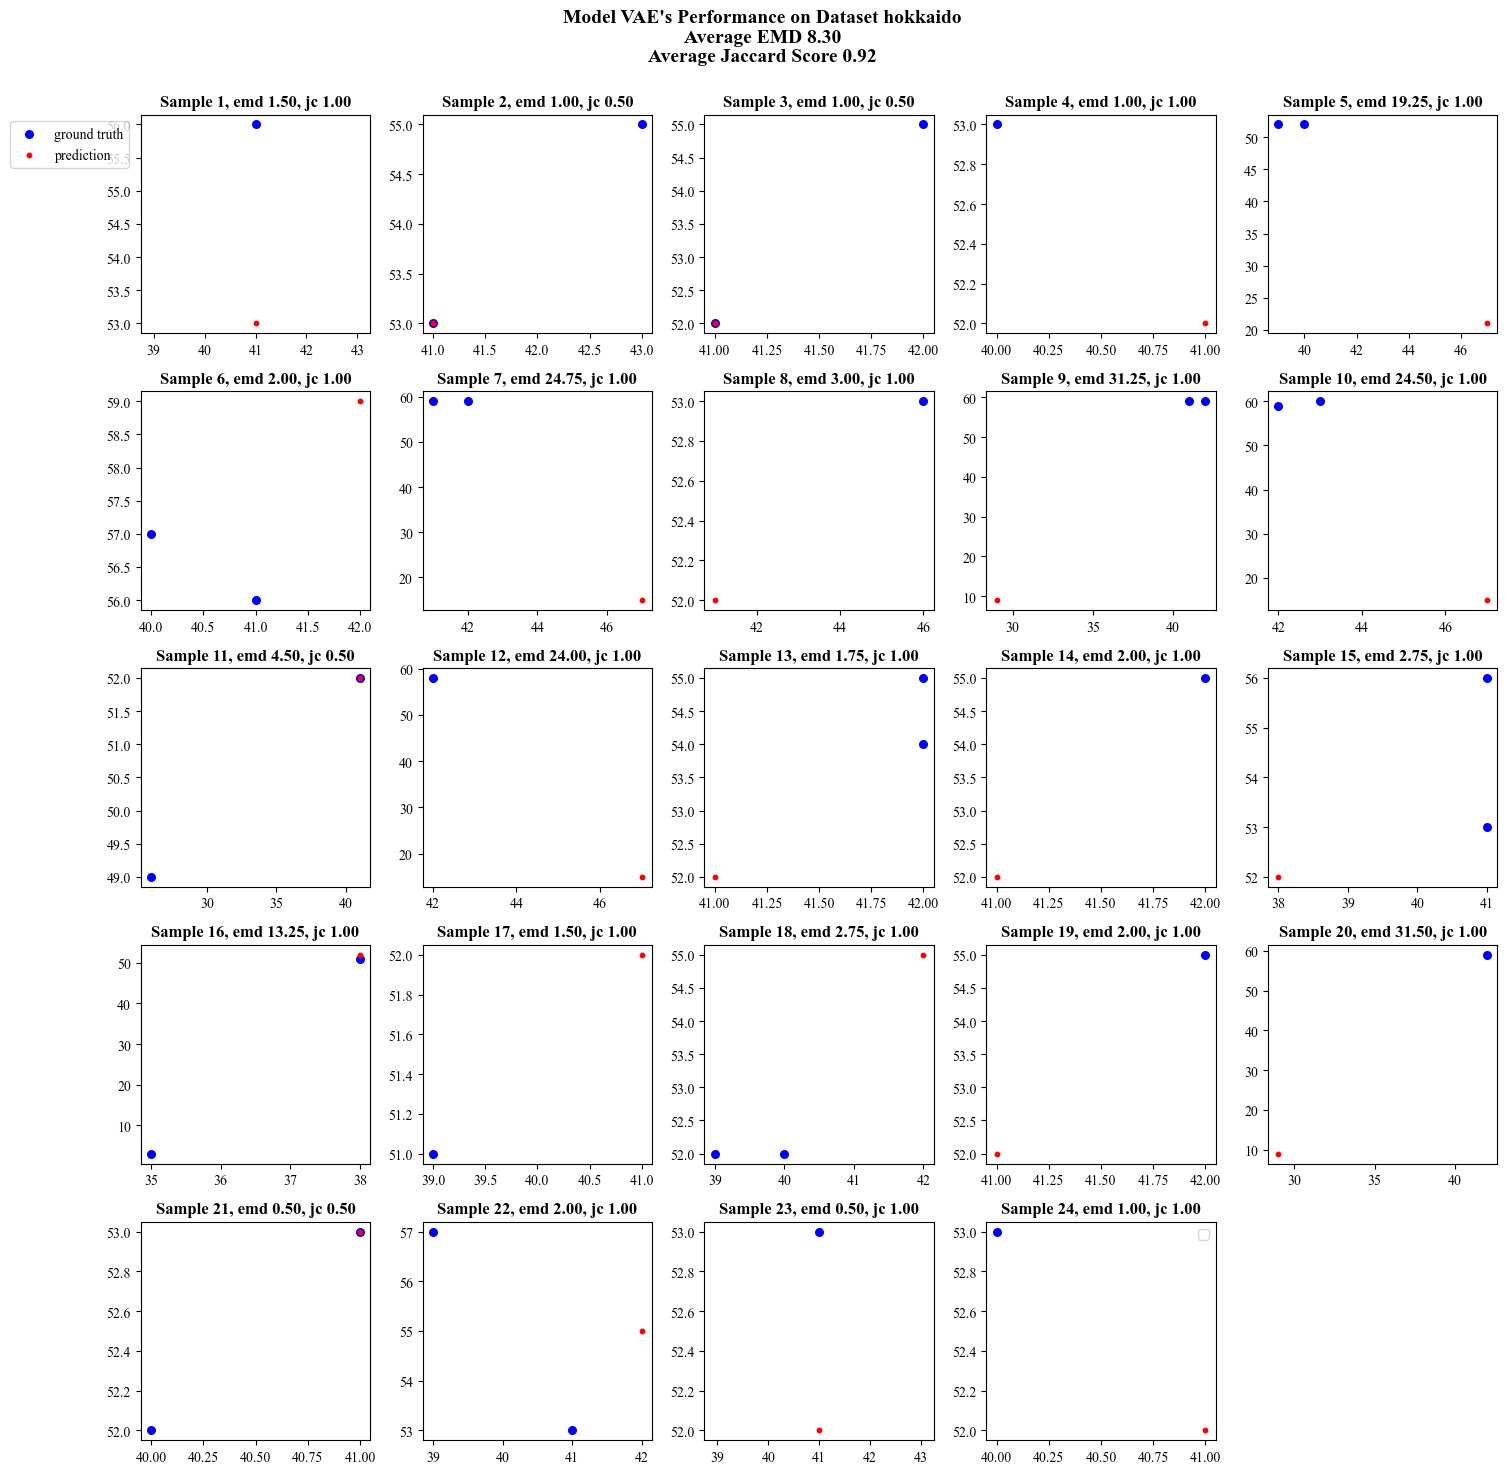

(<Figure size 1500x1500 with 24 Axes>,
 [1.0,
  0.5,
  0.5,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.5,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.5,
  1.0,
  1.0,
  1.0],
 [1.5,
  1.0,
  1.0,
  1.0,
  19.25,
  2.0,
  24.75,
  3.0,
  31.25,
  24.5,
  4.5,
  24.0,
  1.75,
  2.0,
  2.75,
  13.25,
  1.5,
  2.75,
  2.0,
  31.5,
  0.5,
  2.0,
  0.5,
  1.0],
 Counter({(41, 53): 3,
          (41, 52): 10,
          (47, 21): 1,
          (42, 59): 1,
          (47, 15): 3,
          (29, 9): 2,
          (38, 52): 2,
          (42, 55): 2}))

In [9]:

evaluate_and_plot(test_loader, model=model, encoder=encoder, title='VAE', dataset_name=city_name)

- Random Forest

0.9886738045955091
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss
miss


c:\Users\ss348\Desktop\2dinput\experiment\..\utility\visuals.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


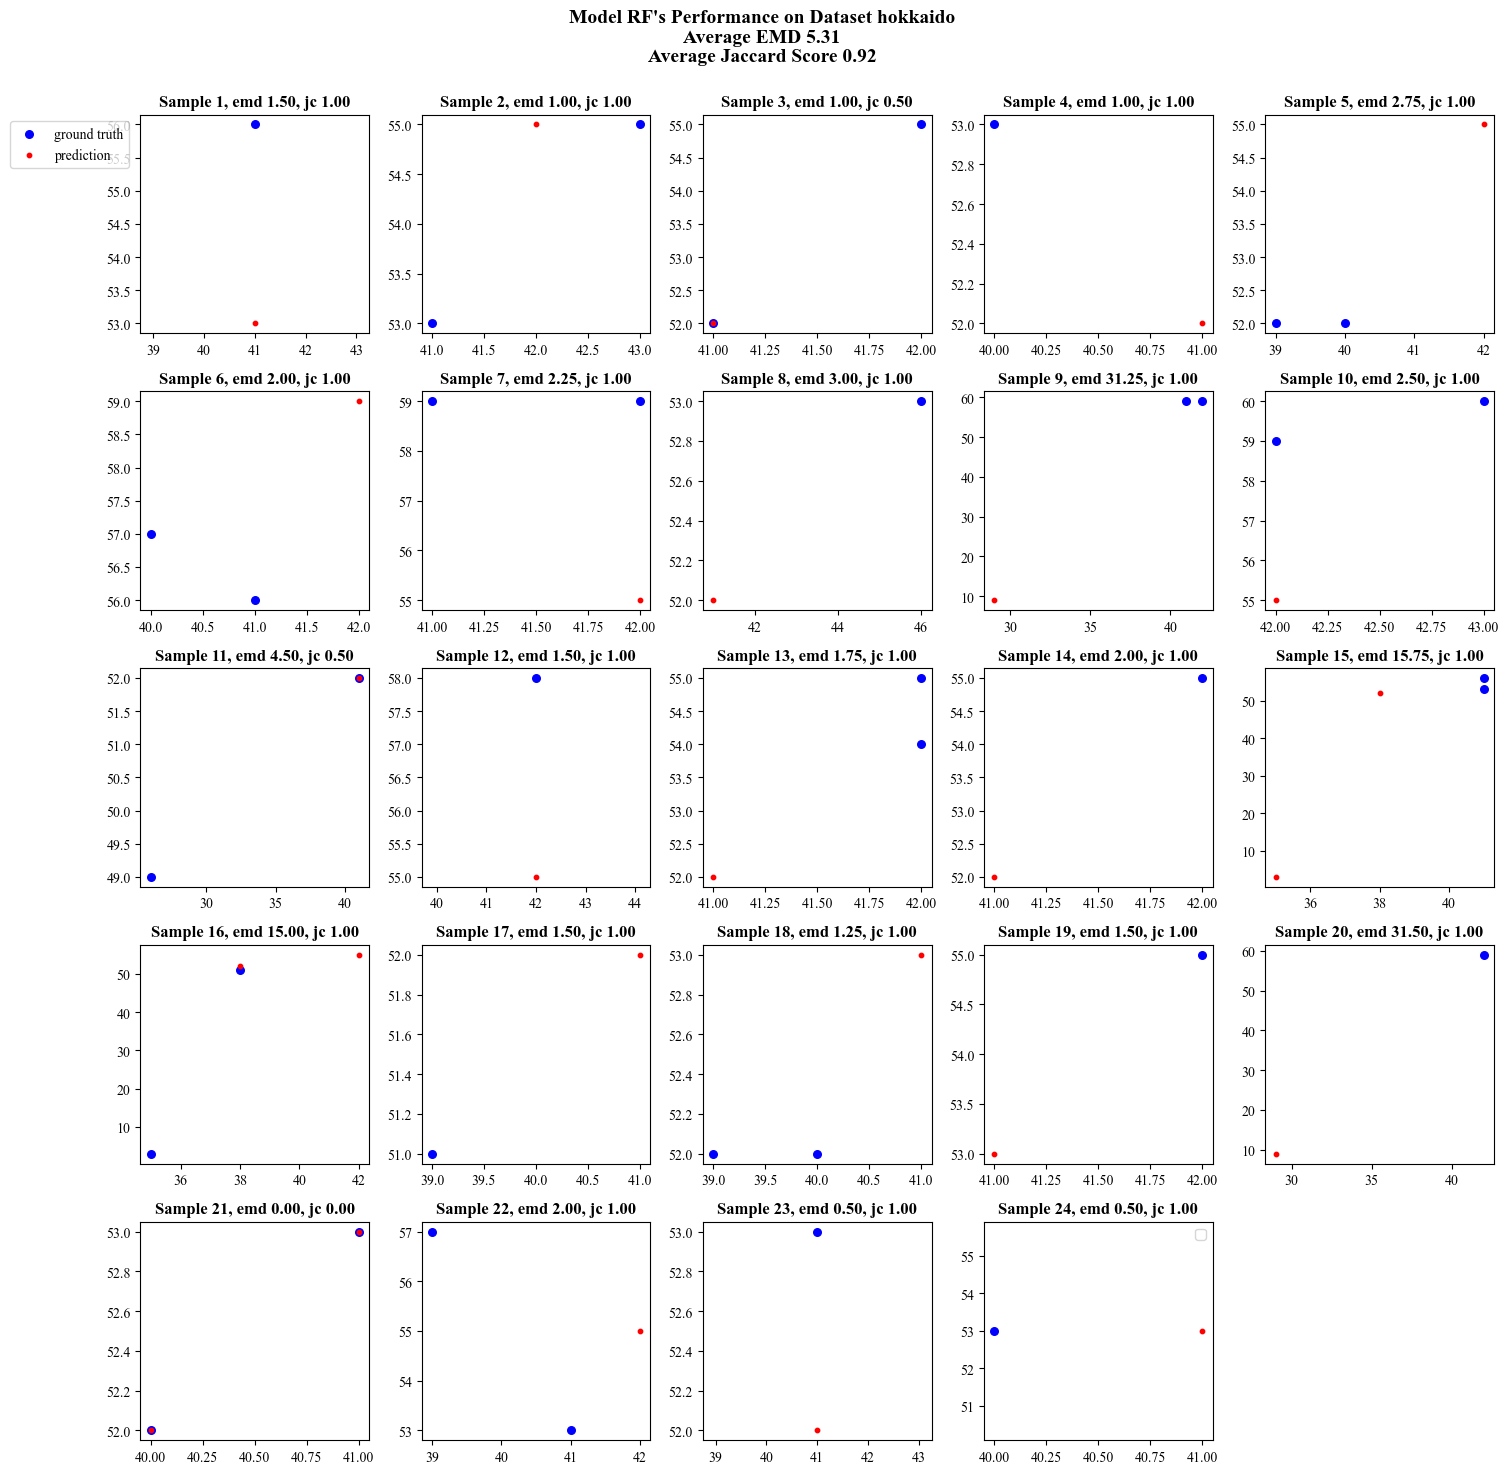

(<Figure size 1500x1500 with 24 Axes>,
 [1.0,
  1.0,
  0.5,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.5,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0],
 [1.5,
  1.0,
  1.0,
  1.0,
  2.75,
  2.0,
  2.25,
  3.0,
  31.25,
  2.5,
  4.5,
  1.5,
  1.75,
  2.0,
  15.75,
  15.0,
  1.5,
  1.25,
  1.5,
  31.5,
  0.0,
  2.0,
  0.5,
  0.5],
 Counter({(41, 53): 5,
          (42, 55): 7,
          (41, 52): 8,
          (42, 59): 1,
          (29, 9): 2,
          (35, 3): 1,
          (38, 52): 2,
          (40, 52): 1}))

In [10]:


model = MLWrapper()
model.fit(loader, val_loader)
evaluate_and_plot(test_loader, model=model, encoder=encoder, title='RF', dataset_name=city_name)